In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium 
from wordcloud import WordCloud

setup date from the past correlation analysis

In [7]:
fatalities_df = pd.read_csv('fatalities_isr_pse_conflict_2000_to_2023.csv')
fatalities_df.head()

,name,date_of_event,age,citizenship,event_location,event_location_district,event_location_region,date_of_death,gender,took_part_in_the_hostilities,place_of_residence,place_of_residence_district,type_of_injury,ammunition,killed_by,notes
0,'Abd a-Rahman Suleiman Muhammad Abu Daghash,2023-09-24,32.0,Palestinian,Nur Shams R.C.,Tulkarm,West Bank,2023-09-24,M,NaN,Nur Shams R.C.,Tulkarm,gunfire,live ammunition,Israeli security forces,Fatally shot by Israeli forces while standing ...
1,Usayed Farhan Muhammad 'Ali Abu 'Ali,2023-09-24,21.0,Palestinian,Nur Shams R.C.,Tulkarm,West Bank,2023-09-24,M,NaN,Nur Shams R.C.,Tulkarm,gunfire,live ammunition,Israeli security forces,Fatally shot by Israeli forces while trying to...
2,'Abdallah 'Imad Sa'ed Abu Hassan,2023-09-22,16.0,Palestinian,Kfar Dan,Jenin,West Bank,2023-09-22,M,NaN,al-Yamun,Jenin,gunfire,live ammunition,Israeli security forces,Fatally shot by soldiers while firing at them ...
3,Durgham Muhammad Yihya al-Akhras,2023-09-20,19.0,Palestinian,'Aqbat Jaber R.C.,Jericho,West Bank,2023-09-20,M,NaN,'Aqbat Jaber R.C.,Jericho,gunfire,live ammunition,Israeli security forces,Shot in the head by Israeli forces while throw...
4,Raafat 'Omar Ahmad Khamaisah,2023-09-19,15.0,Palestinian,Jenin R.C.,Jenin,West Bank,2023-09-19,M,NaN,Jenin,Jenin,gunfire,live ammunition,Israeli security forces,Wounded by soldiers’ gunfire after running awa...


In [8]:
age_mean = fatalities_df['age'].mean()
fatalities_df['age'].fillna(age_mean, inplace=True)
gender_mode = fatalities_df['gender'].mode()[0]
fatalities_df['gender'].fillna(gender_mode, inplace=True)
place_of_residence_mode = fatalities_df['place_of_residence'].mode()[0]
fatalities_df['place_of_residence'].fillna(place_of_residence_mode, inplace=True)
place_of_residence_district_mode = fatalities_df['place_of_residence_district'].mode()[0]
fatalities_df['place_of_residence_district'].fillna(place_of_residence_district_mode, inplace=True)
type_of_injury_mode = fatalities_df['type_of_injury'].mode()[0]
fatalities_df['type_of_injury'].fillna(type_of_injury_mode, inplace=True)
notes_mode = fatalities_df['notes'].mode()[0]
fatalities_df['notes'].fillna(notes_mode, inplace=True)
fatalities_df.drop(['took_part_in_the_hostilities', 'ammunition'], axis=1, inplace=True)

In [9]:
import copy
data = copy.deepcopy(fatalities_df)

In [10]:
cat_cols = ['citizenship', 'event_location','event_location_district', 'event_location_region','gender', 
            'place_of_residence','place_of_residence_district', 'type_of_injury','killed_by']
for x in cat_cols:
    print("column",x,"has nulls:",data[x].hasnans,",count:",data[x].isnull().sum())
    data[x+"_cat"] = pd.CategoricalIndex(data[x]).codes

column citizenship has nulls: False ,count: 0
column event_location has nulls: False ,count: 0
column event_location_district has nulls: False ,count: 0
column event_location_region has nulls: False ,count: 0
column gender has nulls: False ,count: 0
column place_of_residence has nulls: False ,count: 0
column place_of_residence_district has nulls: False ,count: 0
column type_of_injury has nulls: False ,count: 0
column killed_by has nulls: False ,count: 0


In [11]:
data.columns

Index(['name', 'date_of_event', 'age', 'citizenship', 'event_location',
       'event_location_district', 'event_location_region', 'date_of_death',
       'gender', 'place_of_residence', 'place_of_residence_district',
       'type_of_injury', 'killed_by', 'notes', 'citizenship_cat',
       'event_location_cat', 'event_location_district_cat',
       'event_location_region_cat', 'gender_cat', 'place_of_residence_cat',
       'place_of_residence_district_cat', 'type_of_injury_cat',
       'killed_by_cat'],
      dtype='object')

In [12]:
data[['citizenship_cat',
       'event_location_cat', 'event_location_district_cat',
       'event_location_region_cat', 'gender_cat', 'place_of_residence_cat',
       'place_of_residence_district_cat', 'type_of_injury_cat',
       'killed_by_cat']].describe(include="all")

,citizenship_cat,event_location_cat,event_location_district_cat,event_location_region_cat,gender_cat,place_of_residence_cat,place_of_residence_district_cat,type_of_injury_cat,killed_by_cat
count,11124.000000,11124.000000,11124.000000,11124.000000,11124.000000,11124.000000,11124.000000,11124.000000,11124.000000
mean,2.814545,222.079468,8.341514,0.548634,0.872078,262.741999,7.630888,5.071647,1.083783
std,0.580204,121.403074,4.854510,0.857494,0.334018,150.537064,4.502653,1.052770,0.306646
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,155.000000,3.000000,0.000000,1.000000,178.000000,3.000000,5.000000,1.000000
50%,3.000000,194.000000,10.000000,0.000000,1.000000,225.000000,9.000000,5.000000,1.000000
75%,3.000000,321.000000,12.000000,1.000000,1.000000,397.000000,11.000000,5.000000,1.000000
max,3.000000,493.000000,19.000000,2.000000,1.000000,579.000000,19.000000,12.000000,2.000000


In [13]:
data[['citizenship_cat',
       'event_location_cat', 'event_location_district_cat',
       'event_location_region_cat', 'gender_cat', 'place_of_residence_cat',
       'place_of_residence_district_cat', 'type_of_injury_cat',
       'killed_by_cat']].corr()

,citizenship_cat,event_location_cat,event_location_district_cat,event_location_region_cat,gender_cat,place_of_residence_cat,place_of_residence_district_cat,type_of_injury_cat,killed_by_cat
citizenship_cat,1.000000,0.007435,0.031968,-0.206936,0.185143,0.023185,0.074902,0.240178,-0.951583
event_location_cat,0.007435,1.000000,0.080989,0.090513,0.016431,0.663725,0.079720,-0.040298,-0.007197
event_location_district_cat,0.031968,0.080989,1.000000,0.200915,0.025725,0.046407,0.825565,-0.096685,-0.040119
event_location_region_cat,-0.206936,0.090513,0.200915,1.000000,0.052327,0.071052,0.186646,-0.096329,0.153063
gender_cat,0.185143,0.016431,0.025725,0.052327,1.000000,0.025389,0.021924,0.085381,-0.182377
place_of_residence_cat,0.023185,0.663725,0.046407,0.071052,0.025389,1.000000,0.050790,-0.027422,-0.024482
place_of_residence_district_cat,0.074902,0.079720,0.825565,0.186646,0.021924,0.050790,1.000000,-0.053348,-0.081456
type_of_injury_cat,0.240178,-0.040298,-0.096685,-0.096329,0.085381,-0.027422,-0.053348,1.000000,-0.235260
killed_by_cat,-0.951583,-0.007197,-0.040119,0.153063,-0.182377,-0.024482,-0.081456,-0.235260,1.000000


## PCA Analysis

In [14]:
mydata= data[['citizenship_cat', 'event_location_cat',
    'event_location_district_cat', 'event_location_region_cat',
    'gender_cat', 'place_of_residence_cat',
    'place_of_residence_district_cat', 'type_of_injury_cat',
    'killed_by_cat']]
components_range=range(1,len(mydata.columns)+1)
for n in components_range:
    pca = PCA(n_components=n)
    pca.fit(mydata)
    print(n,"components, variance ratio=",pca.explained_variance_ratio_)

1 components, variance ratio= [0.84015491]
2 components, variance ratio= [0.84015491 0.15861851]
3 components, variance ratio= [0.84015491 0.15861851 0.00106262]
4 components, variance ratio= [8.40154912e-01 1.58618508e-01 1.06261982e-03 1.01767769e-04]
5 components, variance ratio= [8.40154912e-01 1.58618508e-01 1.06261982e-03 1.01767769e-04
 3.07056467e-05]
6 components, variance ratio= [8.40154912e-01 1.58618508e-01 1.06261982e-03 1.01767769e-04
 3.07056467e-05 1.89348345e-05]
7 components, variance ratio= [8.40154912e-01 1.58618508e-01 1.06261982e-03 1.01767769e-04
 3.07056467e-05 1.89348345e-05 9.56923562e-06]
8 components, variance ratio= [8.40154912e-01 1.58618508e-01 1.06261982e-03 1.01767769e-04
 3.07056467e-05 1.89348345e-05 9.56923562e-06 2.79835146e-06]
9 components, variance ratio= [8.40154912e-01 1.58618508e-01 1.06261982e-03 1.01767769e-04
 3.07056467e-05 1.89348345e-05 9.56923562e-06 2.79835146e-06
 1.83632963e-07]


In [15]:
data.columns

Index(['name', 'date_of_event', 'age', 'citizenship', 'event_location',
       'event_location_district', 'event_location_region', 'date_of_death',
       'gender', 'place_of_residence', 'place_of_residence_district',
       'type_of_injury', 'killed_by', 'notes', 'citizenship_cat',
       'event_location_cat', 'event_location_district_cat',
       'event_location_region_cat', 'gender_cat', 'place_of_residence_cat',
       'place_of_residence_district_cat', 'type_of_injury_cat',
       'killed_by_cat'],
      dtype='object')

In [16]:
pca = PCA(n_components=len(mydata.columns))
pca.fit(mydata)

PCA(n_components=9)

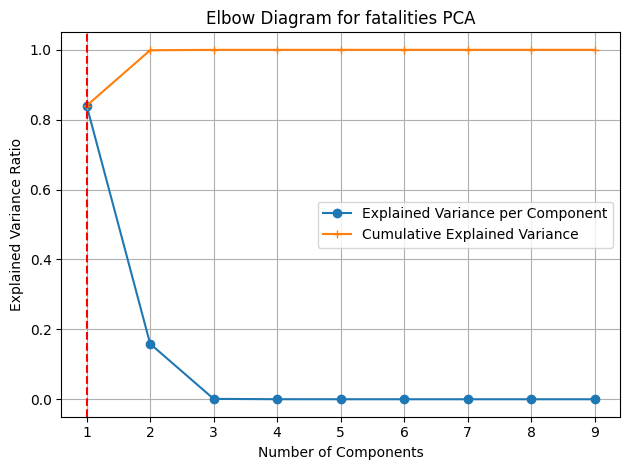

In [30]:
pca = PCA(n_components=len(mydata.columns))
pca.fit(mydata)

explained_variance=pca.explained_variance_ratio_
cumulative_explained_variance=np.cumsum(pca.explained_variance_ratio_)

plt.plot(components_range, explained_variance,marker='o', label='Explained Variance per Component')

plt.plot(components_range, cumulative_explained_variance,marker='+', label='Cumulative Explained Variance')

plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow Diagram for fatalities PCA')
plt.legend()

plt.axvline(x=1, color='red', linestyle='--', label='Suggested number of components')

plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
# Trova il numero di componenti principali per raggiungere o superare il 95% di varianza
target_variance_ratio = 0.95
num_components_to_keep = np.argmax(explained_variance >= target_variance_ratio) + 1
print(num_components_to_keep)

# Ora puoi utilizzare num_components_to_keep nel tuo modello PCA

1


## K-means Clustering

In [18]:
pca = PCA(n_components=2)
pca.fit(mydata)
pca_data=pca.fit_transform(mydata)
pca_data

array([[ 124.43310401,  -11.018131  ],
       [ 124.43310401,  -11.018131  ],
       [ 255.72583534,  184.37188485],
       ...,
       [ -44.51133546, -105.10077393],
       [-195.29329651,    9.08485395],
       [-154.72084194, -167.75956939]])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


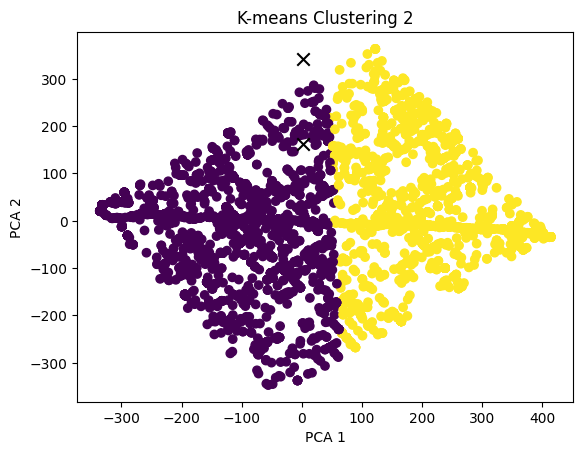

In [19]:
from sklearn.cluster import KMeans

kmeans_2 = KMeans(n_clusters=2, random_state=42)
kmeans_2.fit(mydata)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans_2.labels_, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('K-means Clustering 2')

# cluster centroids
plt.scatter(kmeans_2.cluster_centers_[:, 0], kmeans_2.cluster_centers_[:, 1], s=80, c='black', marker='x')
plt.show()

In [20]:
from sklearn.metrics import silhouette_score
print("evaluation for 2 clusters on data:", silhouette_score(mydata, kmeans_2.labels_))

evaluation for 2 clusters on data: 0.5831316118613485


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


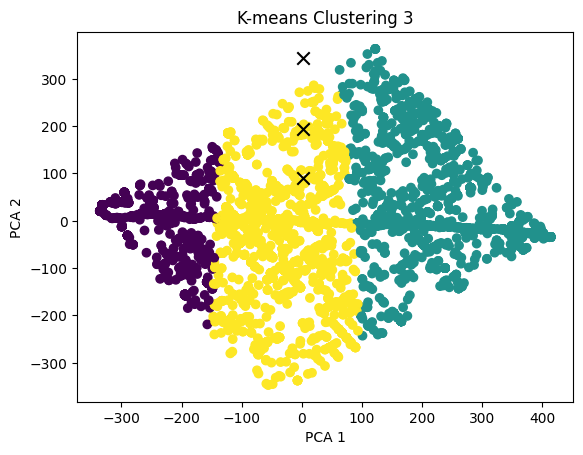

In [21]:
kmeans_3 = KMeans(n_clusters=3, random_state=42)
kmeans_3.fit(mydata)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans_3.labels_, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('K-means Clustering 3')

# Optionally plot cluster centroids
plt.scatter(kmeans_3.cluster_centers_[:, 0], kmeans_3.cluster_centers_[:, 1], s=80, c='black', marker='x')
plt.show()

In [22]:
from sklearn.metrics import silhouette_score
print("evaluation for 3 clusters on data:", silhouette_score(mydata, kmeans_3.labels_))


evaluation for 3 clusters on data: 0.4669481130833015


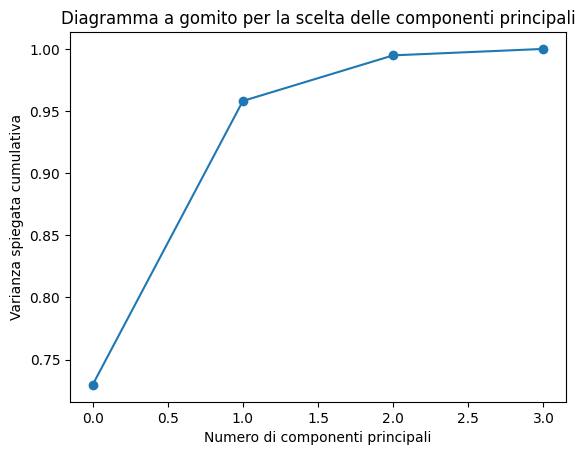

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# Carica il dataset Iris come esempio
data = load_iris()
X = data.data
y = data.target

# Standardizza i dati (importante per la PCA)
X_standardized = StandardScaler().fit_transform(X)

# Inizializza il modello PCA e addestralo sui dati standardizzati
pca = PCA()
principal_components = pca.fit_transform(X_standardized)

# Visualizza la varianza spiegata cumulativa
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Visualizza il diagramma a gomito per aiutare a scegliere il numero di componenti principali
plt.plot(explained_variance_ratio, marker='o')
plt.xlabel('Numero di componenti principali')
plt.ylabel('Varianza spiegata cumulativa')
plt.title('Diagramma a gomito per la scelta delle componenti principali')
plt.show()


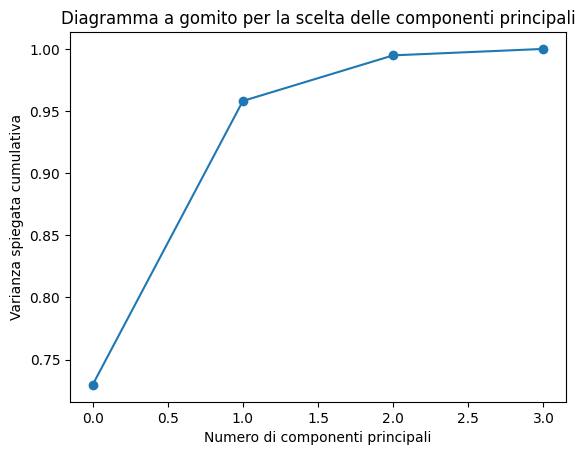

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# Carica il dataset Iris come esempio
data = load_iris()
X = data.data

# Standardizza i dati (importante per la PCA)
X_standardized = StandardScaler().fit_transform(X)

# Inizializza il modello PCA e addestralo sui dati standardizzati
pca = PCA()
principal_components = pca.fit_transform(X_standardized)

# Visualizza la varianza spiegata cumulativa
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Visualizza il diagramma a gomito
plt.plot(explained_variance_ratio, marker='o')
plt.xlabel('Numero di componenti principali')
plt.ylabel('Varianza spiegata cumulativa')
plt.title('Diagramma a gomito per la scelta delle componenti principali')
plt.show()


In [25]:
# Trova il numero di componenti principali per raggiungere o superare il 95% di varianza
target_variance_ratio = 0.95
num_components_to_keep = np.argmax(explained_variance_ratio >= target_variance_ratio) + 1
print(num_components_to_keep)

# Ora puoi utilizzare num_components_to_keep nel tuo modello PCA


2
